# Card Classifer using Pytorch

## Install/Import dependencies

In [1]:
%%bash
set -euo pipefail

# 0) (optional) install uv if not present
command -v uv >/dev/null || (curl -LsSf https://astral.sh/uv/install.sh | sh && export PATH="$HOME/.cargo/bin:$PATH")

# 1) Make sure Python 3.11 is available to uv
uv python install 3.11 >/dev/null

# 2) Create venv pinned to Python 3.11
uv venv --python 3.11 .venv >/dev/null

# 3) Activate venv and install deps (plus ipykernel for notebook integration)
source .venv/bin/activate
uv pip install -q -r requirements.txt ipykernel

# 4) Register as a Jupyter kernel
KNAME="py311-$(basename "$PWD")"
python -m ipykernel install --user --name "$KNAME" --display-name "Python 3.11 ($(basename "$PWD"))" >/dev/null

python -V
echo "Kernel installed: $KNAME"

Python 3.11 is already installed
Using CPython 3.11.14
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate


Python 3.11.14
Kernel installed: py311-PlayingCardClassifier


In [2]:
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import sys, timm, torch, torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import numpy as np, pandas as pd, matplotlib.pyplot as plt

try:
    from tqdm.autonotebook import tqdm
except Exception:
    from tqdm import tqdm


print(f"System Version: {sys.version}")
print(f"Pytorch Version: {torch.__version__}")
print(f"TorchVision Version: {torchvision.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")

/home/ugrads/majors/nikoparas1/Workspace/ML/PlayingCardClassifier/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


System Version: 3.11.14 (main, Oct 28 2025, 12:11:26) [Clang 20.1.4 ]
Pytorch Version: 2.9.0+cu128
TorchVision Version: 0.24.0+cu128
Numpy Version: 2.3.4
Pandas Version: 2.3.3


## Import dataset

In [3]:
import gdown, zipfile, shutil, tempfile
from pathlib import Path

if all((Path("data") / d).is_dir() for d in ("train", "test", "valid")):
    print("OK: data/ already present.")
else:
    stage = Path(tempfile.mkdtemp(prefix="_gdf_"))
    gdown.download_folder(
        "https://drive.google.com/drive/u/2/folders/1UbhLr98WC2zA-bSVpd_hlYZHOe6gNW5y",
        output=str(stage),
        quiet=False,
        use_cookies=False,
    )
    zips = list(stage.rglob("*.zip"))
    assert zips, "No .zip found in the shared folder."
    z = zips[0]
    tmp = Path(tempfile.mkdtemp(prefix="_unz_"))
    zipfile.ZipFile(z).extractall(tmp)
    cand = [p for p in tmp.iterdir() if p.is_dir()]
    src = next(
        (p for p in cand if p.name.lower() == "data"),
        cand[0] if len(cand) == 1 else tmp,
    )
    shutil.rmtree("data", ignore_errors=True)
    shutil.move(str(src), "data")
    shutil.rmtree(stage, ignore_errors=True)
    shutil.rmtree(tmp, ignore_errors=True)
    assert all(
        (Path("data") / d).is_dir() for d in ("train", "test", "valid")
    ), "Expected subdirs missing in ./data"
    print("OK: downloaded and prepared ./data (train/test/valid).")

OK: data/ already present.


## Implement CardDataset and CardClassifier classes

In [4]:
class CardDataset(Dataset):
    def __init__(self, root, transform=None):
        self.data = ImageFolder(root=root, transform=transform)
        pass

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

    @property
    def classes(self):
        return self.data.classes


class CardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(CardClassifier, self).__init__()
        self.base_model = timm.create_model(
            model_name="efficientnet_b0", pretrained=True
        )
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        self.classifier = nn.Linear(enet_out_size, num_classes)

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

## Load datasets and set up Dataloaders

In [5]:
train_dir = "./data/train"
test_dir = "./data/test"
valid_dir = "./data/valid"

target_to_class = {v: k for k, v, in ImageFolder(train_dir).class_to_idx.items()}
print(target_to_class)

transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

train_dataset = CardDataset(root=train_dir, transform=transform)
test_dataset = CardDataset(root=test_dir, transform=transform)
valid_dataset = CardDataset(root=valid_dir, transform=transform)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

## Training Loop

In [10]:
epochs = 5
lr = 1e-3
num_classes = 53
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Training on {device.type} hardware")

model = CardClassifier(num_classes=num_classes)
model.to(device=device)

# Initialize Loss function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_dataloader, desc="Training Loop"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_dataloader, desc="Validation Loop"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(valid_dataloader.dataset)
    val_losses.append(val_loss)
    print(
        f"Epoch {epoch + 1}/{epochs} - Train loss: {train_loss}, Validation loss: {val_loss}"
    )

Training on cuda hardware


Validation Loop: 100%|██████████| 9/9 [00:00<00:00, 12.98it/s]


Epoch 1/5 - Train loss: 1.5719572499566414, Validation loss: 0.3126012775133241


Validation Loop: 100%|██████████| 9/9 [00:00<00:00, 13.07it/s]


Epoch 2/5 - Train loss: 0.5468882626276327, Validation loss: 0.20435121149387


Validation Loop: 100%|██████████| 9/9 [00:00<00:00, 12.65it/s]


Epoch 3/5 - Train loss: 0.3438686636068388, Validation loss: 0.16756041927157708


Validation Loop: 100%|██████████| 9/9 [00:00<00:00, 10.28it/s]


Epoch 4/5 - Train loss: 0.24663777557149888, Validation loss: 0.19597513765658972


Validation Loop: 100%|██████████| 9/9 [00:00<00:00, 11.75it/s]

Epoch 5/5 - Train loss: 0.1856922476795763, Validation loss: 0.10353709414320172


## Loss Visualization

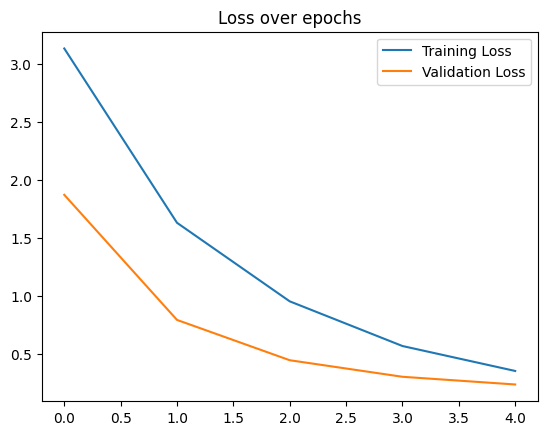

In [7]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Evaluate Results

In [8]:
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

def visualize_predictions(original_image, probabilities, class_names):
    _, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    axes[0].imshow(original_image)
    axes[0].axis("off")
    
    axes[1].barh(class_names, probabilities)
    axes[1].set_xlabel("Probability")
    axes[1].set_title("Class Predictions")
    axes[1].set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()

In [9]:
class_names = [target_to_class[i] for i in range(len(target_to_class))]
samples = test_dataset.data.samples
paths = [samples[i][0] for i in getattr(test_dataset, "indices", range(len(samples)))]
probs = []
preds = []
labels = []
with torch.no_grad():
    for x, y in test_dataloader:
        p = torch.softmax(model(x.to(device)), 1).cpu()
        probs.append(p)
        preds.append(p.argmax(1))
        labels.append(y)
probs = torch.cat(probs).numpy()
preds = torch.cat(preds).numpy()
labels = torch.cat(labels).numpy()
for i, (pred, prob) in enumerate(zip(preds, probs)):
    print(paths[i], class_names[int(pred)], float(prob[int(pred)]))
print("Accuracy:", np.mean(preds == labels))

./data/test/ace of clubs/1.jpg ace of clubs 0.9364914298057556
./data/test/ace of clubs/2.jpg ace of clubs 0.9892821311950684
./data/test/ace of clubs/3.jpg ace of clubs 0.8697327375411987
./data/test/ace of clubs/4.jpg ace of clubs 0.9972104430198669
./data/test/ace of clubs/5.jpg ace of clubs 0.9581373929977417
./data/test/ace of diamonds/1.jpg ace of diamonds 0.9903276562690735
./data/test/ace of diamonds/2.jpg ace of diamonds 0.9262068271636963
./data/test/ace of diamonds/3.jpg ace of diamonds 0.9820401072502136
./data/test/ace of diamonds/4.jpg ace of diamonds 0.9955167174339294
./data/test/ace of diamonds/5.jpg ace of diamonds 0.9916397929191589
./data/test/ace of hearts/1.jpg ace of hearts 0.9252117276191711
./data/test/ace of hearts/2.jpg ace of hearts 0.9172123670578003
./data/test/ace of hearts/3.jpg ace of hearts 0.980471134185791
./data/test/ace of hearts/4.jpg ace of hearts 0.9254147410392761
./data/test/ace of hearts/5.jpg ace of hearts 0.9248794913291931
./data/test/ace 